# Multi-hazard risk assessment

In this notebook, we will perform a **multi-hazard risk assessmente** for education infrastructure data within a country. The assessment is based on combining hazard data (e.g., flood depths) with OpenStreetMap feature data.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., hospitals) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the risk assessment:**  
   We will overlay the hazard data with the feature information.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated exposure using graphs and maps.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install damagescanner==0.9b13
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [2]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely
from tqdm import tqdm

import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD
from statistics import mode

from lonboard import viz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [11]:
country_full_name = 'Haiti'
country_iso3 = 'HTI'

### Specify the hazards of interest
To help us performing a consistent analysis on which hazards we include, its most convenient to provide a list of the hazards at the start of our analysis.

In [6]:
hazards = ['Earthquake','Flood','Tropical_Cyclone']

## 2. Loading the Data
In this step, we will prepare and load two key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

### Infrastructure Data

We will perform this example analysis for Jamaica. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. 

In [4]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the education data.

In [12]:
%%time
features = read_osm_data(infrastructure_path,asset_type='education')

CPU times: total: 36.4 s
Wall time: 45.6 s


In [19]:
sub_types = features.object_type.unique()
sub_types

array(['school', 'library', 'college', 'kindergarten', 'university'],
      dtype=object)

### Vulnerability data
We will collect all the vulnerability curves for each of the asset types and for each of the hazards. Important to note is that national or local-scale analysis requires a thorough check which curves can and should be used!

In [15]:
vulnerability_path = "https://zenodo.org/records/13889558/files/Table_D2_Hazard_Fragility_and_Vulnerability_Curves_V1.1.0.xlsx?download=1"

In [18]:
collect_vulnerability_dataframes = {}
for hazard in hazards:
    if hazard == 'Earthquake':
        collect_vulnerability_dataframes[hazard] = pd.read_excel(vulnerability_path,sheet_name='E_Vuln_PGA ')
    elif hazard == 'Flood':
        collect_vulnerability_dataframes[hazard] = pd.read_excel(vulnerability_path,sheet_name='F_Vuln_Depth')
    elif hazard == 'Tropical_Cyclone':
        collect_vulnerability_dataframes[hazard] = pd.read_excel(vulnerability_path,sheet_name='W_Vuln_V10m')   

In [25]:
collect_vulnerability_dataframes['Earthquake']

,ID number,E1.1,E1.1a,E1.1b,E1.2,E1.2a,E1.2b,E1.3,E1.3a,E1.3b,...,E20.2b,E20.3,E20.3a,E20.3b,E20.4,E20.4a,E20.4b,E21.11,E21.11a,E21.11b
0,Infrastructure type,Power plant,Power plant,Power plant,Power plant,Power plant,Power plant,Power plant,Power plant,Power plant,...,Others,Others,Others,Others,Others,Others,Others,Educational facilities,Educational facilities,Educational facilities
1,Infrastructure type details,Small generation facilities with anchored comp...,Small generation facilities with anchored comp...,Small generation facilities with anchored comp...,Small generation facilities with unanchored co...,Small generation facilities with unanchored co...,Small generation facilities with unanchored co...,Medium/large power with anchored components,Medium/large power with anchored components,Medium/large power with anchored components,...,small lift - unanchored,medium/large lift - anchored,medium/large lift - anchored,medium/large lift - anchored,medium/large unanchored,medium/large unanchored,medium/large unanchored,Reinforced concrete four-story building,Reinforced concrete four-story building,Reinforced concrete four-story building
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Peak Ground Acceleration (g),Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,...,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor,Damage factor
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,3.8,0.999778,0.799687,0.999839,0.99991,0.799872,0.999935,0.998556,0.79798,0.998948,...,0.974057,0.972474,0.74917,0.972626,0.972522,0.74919,0.972663,NaN,NaN,NaN
81,3.85,0.999797,0.799715,0.999853,0.999917,0.799883,0.99994,0.998654,0.798115,0.99902,...,0.974798,0.973297,0.750582,0.973439,0.973341,0.750601,0.973474,NaN,NaN,NaN
82,3.9,0.999815,0.799739,0.999866,0.999924,0.799893,0.999945,0.998744,0.798241,0.999086,...,0.975512,0.974088,0.751947,0.974223,0.974129,0.751964,0.974255,NaN,NaN,NaN
83,3.95,0.999831,0.799761,0.999877,0.999931,0.799902,0.99995,0.998828,0.798358,0.999147,...,0.976202,0.97485,0.753266,0.974977,0.974888,0.753282,0.975007,NaN,NaN,NaN


And now select a curve to use for each different subtype we are analysing for each of the hazards

In [26]:
selected_curves_dict = {}
selected_curves_dict['Earthquake'] = dict(zip(sub_types,['E21.11','E21.11','E21.11','E21.11','E21.11']))
selected_curves_dict['Flood'] = dict(zip(sub_types,['F21.11','F21.10','F21.10','F21.10','F21.10']))
selected_curves_dict['Tropical_Cyclone'] = dict(zip(sub_types,['W21.2','W21.3','W21.4','W21.5','W21.10']))

We need to ensure that we correctly name the index of our **damage_curves** `pd.DataFrame`, and that we convert the index values to the same unit as the hazard data.

In [27]:
hazard_intensity_metric = {'Earthquake': 'PGA',
                        'Flood' : 'Depth',
                        'Tropical_Cyclone' : 'WindSpeed'}

aligning_curve_and_hazard_data = {'Earthquake': 980,
                        'Flood' : 100,
                        'Tropical_Cyclone' : 1}


And then we can populate a `dict()` with the **damage curves** for each hazard included in our analysis.

In [31]:
damage_curves_all_hazards = {}

for hazard in hazards:
    vul_df = collect_vulnerability_dataframes[hazard]
    damage_curves = vul_df[['ID number']+list(selected_curves_dict[hazard].values())]
    damage_curves = damage_curves.iloc[4:125,:]
    damage_curves.set_index('ID number',inplace=True)
    damage_curves.index = damage_curves.index.rename(hazard_intensity_metric[hazard])  
    damage_curves = damage_curves.astype(np.float32)
    damage_curves.columns = sub_types
    damage_curves = damage_curves.fillna(method='ffill')
    damage_curves.index = damage_curves.index*aligning_curve_and_hazard_data[hazard]

    damage_curves_all_hazards[hazard] = damage_curves

### Maximum damages
One of the most difficult parts of the assessment is to define the maximum reconstruction cost of particular assets. Here we provide a baseline set of values, but these should be updated through national consultations.

Locations of education facilities are (somewhat randomly) geotagged as either points or polygons. This matters quite a lot for the maximum damages. For polygons, we would use damage per square meter, whereas for points, we would estimate the damage to the entire asset at once. Here we take the approach of converting the points to polygons, and there define our maximum damages in dollar per square meter. 

In [32]:
maxdam_dict = {'community_centre' : 1000, 
               'school' : 1000, 
               'kindergarten' : 1000, 
               'university' : 1000, 
               'college' : 1000,
               'library' : 1000
              }

In [33]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

And check if any of the objects are missing from the dataframe.

In [34]:
missing = set(sub_types) - set(maxdam.object_type)

if len(missing) > 0:
    print(f"Missing object types in maxdam: \033[1m{', '.join(missing)}\033[0m. Please add them before you continue.")

### Ancilliary data for processing

In [39]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [65]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

## 3. Preparing the Data

Clip the hazard data to the country of interest.

In [40]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [41]:
country_box = shapely.box(country_bounds.minx.values,country_bounds.miny.values,country_bounds.maxx.values,country_bounds.maxy.values)[0]

### Hazard Data
For this example, we make use of the flood, earthquake and tropical cyclone data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

For our risk assessment, we will need to define a set of return periods for each of the hazards, and create a hazard_dict for each of the hazards well.

In [42]:
hazard_return_periods = {'Earthquake': [250,475,975,1500,2475],
                        'Flood' : [2,5,10,50,100,200,500,1000],
                        'Tropical_Cyclone' : [25,50,100,250]    
}

In [43]:
hazard_dict_per_hazard = {}

for hazard in hazards:
    hazard_dict = {}
    for return_period in hazard_return_periods[hazard]:
        if hazard == 'Earthquake':
            hazard_map = xr.open_dataset(f"https://hazards-data.unepgrid.ch/PGA_{return_period}y.tif", engine="rasterio")
        elif hazard == 'Flood':
            hazard_map = xr.open_dataset(f"https://hazards-data.unepgrid.ch/global_pc_h{return_period}glob.tif", engine="rasterio")
        elif hazard == 'Tropical_Cyclone':
            hazard_map = xr.open_dataset(f"https://hazards-data.unepgrid.ch/Wind_T{return_period}.tif", engine="rasterio")
    
        hazard_dict[return_period] = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                         miny=country_bounds.miny.values[0],
                         maxx=country_bounds.maxx.values[0],
                         maxy=country_bounds.maxy.values[0]
                        )
    hazard_dict_per_hazard[hazard] = hazard_dict

Set the return periods and download the hazard data

## 4. Performing the Risk Assessment
We will use the DamageScanner approach. This is a fully optimised exposure, vulnerability damage and risk calculation method, that can capture a wide range of inputs to perform such an assessment.

In [46]:
save_asset_risk_results = {}
for hazard in hazards:
  save_asset_risk_results[hazard] = DamageScanner(hazard_dict_per_hazard[hazard], 
                                                   features, 
                                                   curves=damage_curves_all_hazards[hazard], 
                                                   maxdam=maxdam
                                                       ).risk(hazard_dict_per_hazard[hazard]
    )


Risk Calculation: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:30<00:00,  7.73s/it]


In [57]:
combine_results = []
for hazard in hazards:
    results = save_asset_risk_results[hazard]
    combine_results.append(pd.DataFrame(results.rename(columns={'risk': hazard})[hazard]))

risk_outcomes = features.merge(pd.concat(combine_results,axis=1),right_index=True,left_index=True,how='outer')

## 5. Save the Results
For further analysis, we can save the results in their full detail, or save summary estimates per subnational unit 

In [72]:
risk_outcomes.to_file(f'Healthcare_Multi_Risk_{'_'.join(hazards)}.gpkg')

In [66]:
admin1_country = admin1.loc[admin1.sov_a3 == country_iso3]

In [67]:
risk_outcomes = risk_outcomes.sjoin(admin1_country[['adm1_code','name','geometry']])

In [69]:
admin1_damage = admin1_country.merge(risk_outcomes[['name']+hazards].groupby('name').sum(),
                                     left_on='name',
                                     right_on='name',
                                     how='outer')[['name','adm1_code','geometry']+hazards]

In [73]:
admin1_damage.to_file(f'Admin1_Healthcare_Multi_Risk_{'_'.join(hazards)}.gpkg')

## 6. Visualising the results


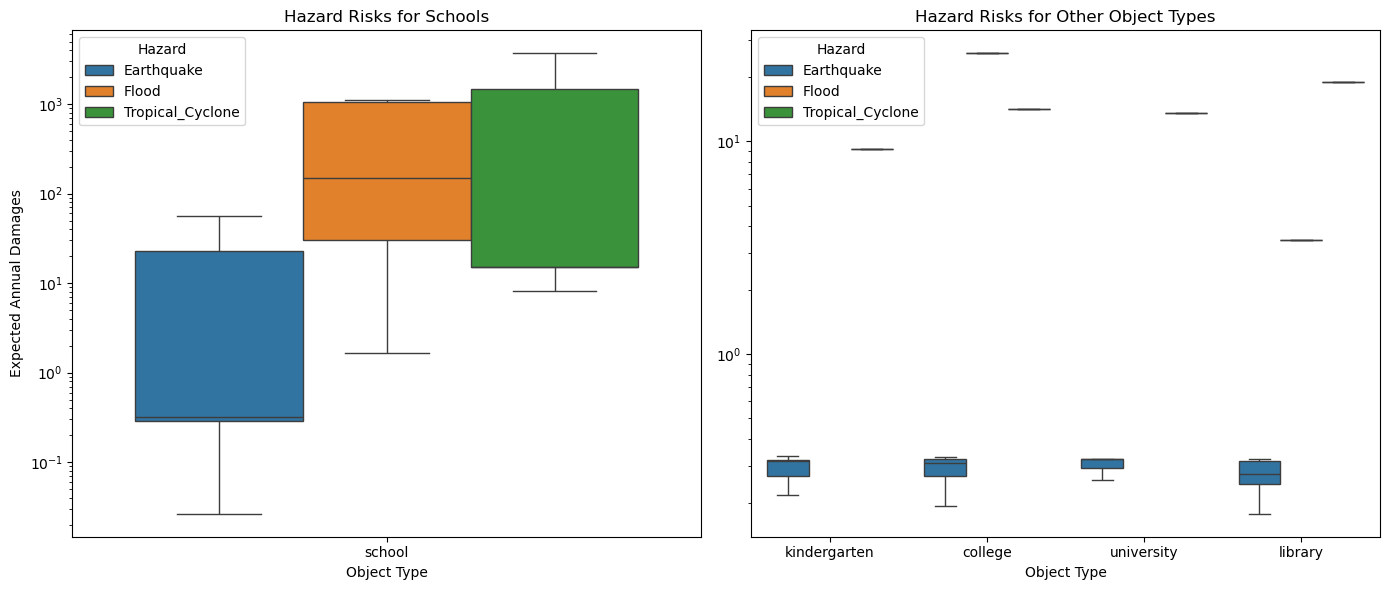

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter relevant columns
hazard_columns = ['Earthquake', 'Flood', 'Tropical_Cyclone']

# Convert to long format for Seaborn
risk_long = risk_outcomes.melt(id_vars=['object_type'], value_vars=hazard_columns, 
                               var_name='Hazard', value_name='Risk_Level')

# Remove NaN values
risk_long = risk_long.dropna()

# Separate schools from other object types
schools = risk_long[risk_long['object_type'] == 'school']
others = risk_long[risk_long['object_type'] != 'school']

# Set figure size
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Create a boxplot for schools
sns.boxplot(data=schools, x='object_type', y='Risk_Level', hue='Hazard', ax=axes[0],showfliers=False)
axes[0].set_title('Hazard Risks for Schools')
axes[0].set_xlabel('Object Type')
axes[0].set_ylabel('Expected Annual Damages')
axes[0].legend(title='Hazard')

# Create a boxplot for other object types
sns.boxplot(data=others, x='object_type', y='Risk_Level', hue='Hazard', ax=axes[1],showfliers=False)
axes[1].set_title('Hazard Risks for Other Object Types')
axes[1].set_xlabel('Object Type')
axes[1].set_ylabel('')
axes[1].legend(title='Hazard')

# Improve readability
for ax in axes:
    ax.set_yscale('log')  # Use log scale for better visualization if values vary widely

# Show plot
plt.tight_layout()
plt.show()
